In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-on-financial-tweets/stockerbot-export1.csv
/kaggle/input/sentiment-analysis-on-financial-tweets/tweet_sentiment.csv


In [2]:
import sys
print(sys.version)

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


In [3]:
!python --version

Python 3.7.12


In [4]:
!pip install tweepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 3.0 MB/s eta 0:00:00


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os



# For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("stopwords")
nltk.download('words')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('omw-1.4')

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf


# For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# Import and Illustration of the DataSet

In [6]:
# Importing the Dataset
df = pd.read_csv('../input/sentiment-analysis-on-financial-tweets/tweet_sentiment.csv')
df = df.rename(columns={'cleaned_tweets': 'text'})

df.head()

,text,sentiment
0,video offic mind busi david solomon tell gs in...,0
1,price lumber lb f sinc hit ytd high maci turna...,0
2,say american dream dead,-1
3,barri silbert extrem optimist bitcoin predict ...,1
4,satellit avoid attack space junk circl earth paid,-1


In [7]:
# Removing any Duplicates from the DataSet
df = df.drop_duplicates()

In [8]:
# Checking if any Texts have unsigned Sentiment Values
df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [9]:
# Remvoing unsigned Text from the Dataset
df.dropna(axis=0, inplace=True)

In [10]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [11]:
# Importing the library Plotly to illustrate the Dataset

import plotly.express as px

fig = px.pie(df, names='sentiment', title ='A Pie Chart of the Sentiment Distribution of the Dataset')
fig.show()


# Changing the Sentiments values from a Text Based System to a Numeric Based System 

In [12]:
sentiment_array = []

for i in df["sentiment"]:
    if ( i == "positive"):
        sentiment_array.append(1)
    elif ( i == "negative"):
        sentiment_array.append(-1)
    elif ( i == "neutral"):
        sentiment_array.append(0)
        
#df["sentiment"] = sentiment_array
#

In [13]:
df.head()

,text,sentiment
0,video offic mind busi david solomon tell gs in...,0
1,price lumber lb f sinc hit ytd high maci turna...,0
2,say american dream dead,-1
3,barri silbert extrem optimist bitcoin predict ...,1
4,satellit avoid attack space junk circl earth paid,-1


# Cleaning the Text from the DataSet

In [14]:
# Assigning the English stop words. 
stop_words = set(stopwords.words("english"))

In [15]:
# Function to clean each line of Text in the Dataset and Tokenize it.

def text_cleaner_with( data ):
    
    # Tokenization of the line
    data = data.split()
    
    # Removing all stop words from the text
    data = [ s for s in data if s not in stop_words]
    
    # Using isalpha() to ensure that each token consists of alphabets and not punctuation  
    data = [p for p in data if p.isalpha()]
    
    # Lemmatization
    data = [WordNetLemmatizer().lemmatize(l) for l in data]
    

    
    return data

In [16]:
def text_cleaner( data ):
    
    # Tokenization of the line
    data = data.split()
    
    # Removing all stop words from the text
    data = [ s for s in data if s not in stop_words]
    
    # Using isalpha() to ensure that each token consists of alphabets and not punctuation  
    data = [p for p in data if p.isalpha()]
    
    # Lemmatization
    data = [WordNetLemmatizer().lemmatize(l) for l in data]
    
    # Stemming
    data = [PorterStemmer().stem(s) for s in data]
    
    return data

**Illustration of how Stemming effects the DataSet**

In [17]:
print("Without Stemming")
print("The text before cleaing :" ,df["text"][4])
print("The text after cleaing:", text_cleaner_with(df["text"][5]), "\n")

print("With Stemming")
print("The text before cleaing :" ,df["text"][4])
print("The text after cleaing:", text_cleaner(df["text"][5]), "\n")

Without Stemming
The text before cleaing : satellit avoid attack space junk circl earth paid
The text after cleaing: ['david', 'butler', 'favorit', 'fang', 'stock', 'realmoneysod', 'alphabet', 'facebook'] 

With Stemming
The text before cleaing : satellit avoid attack space junk circl earth paid
The text after cleaing: ['david', 'butler', 'favorit', 'fang', 'stock', 'realmoneysod', 'alphabet', 'facebook'] 



In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

In [19]:
# Calling the Text Cleaner Function and Assigning the Text from the Dataset to a Variable 
X = list(map(text_cleaner, df["text"]))

In [20]:
#Assigning the Sentiment values from the Dataset to a Variable
y = df["sentiment"]

In [21]:
print(X[0])
print(y[0])

['video', 'offic', 'mind', 'busi', 'david', 'solomon', 'tell', 'g', 'intern', 'learn', 'wa']
0


# Tokenizing and Padding the Text


In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len = 50

# A function to tokenize the input text and convert them into a sequence 
# of integers after which pad them to ensure that each vector is of same length
def tokenize_pad_sequences(text):

    # Tokenizing the text
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)

    # Converting the tokenized text into integers
    X = tokenizer.texts_to_sequences(text)
    
    # Padding the tokens to ensure they are the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)

    return X, tokenizer

In [23]:
print( "Before using the tokenize function \n", df['text'][0] )

X, tokenizer = tokenize_pad_sequences(df['text'])
print("\nAfter using the tokenize function \n", X[0])

Before using the tokenize function 
 video offic mind busi david solomon tell gs intern learn wa

After using the tokenize function 
 [ 402  703 1979  502 1534 1449  186   71 2419 3003    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


# Splitting Dataset

In [24]:
# Splitting the dataset to create another dataset that will be used for validation
# Splitting the dataset into training and testing vectors using a test size of 20% and randoming selecting the data everytime the programme runs

y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (13196, 50) (13196, 3)
Validation Set -> (4399, 50) (4399, 3)
Test Set -> (4399, 50) (4399, 3)


# Defining and Training the Model

In [25]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
learning_rate = 0.1                           # How much to change the model in response to estimated errors
epochs = 30                                   # Number of pass overs over the entire dataset
decay_rate = learning_rate / epochs           # Used to decay the learning rate for better optimization and generalization
momentum = 0.8                                # Used to help accelerate gradients in the correct direction enabling faster converging

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))   
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0))                          
model.add(Dense(3, activation='softmax'))

2022-08-15 20:41:33.313091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 20:41:33.317936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 20:41:33.318720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 20:41:33.320906: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

In [27]:
# Compiling the Model
model.compile( loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'] )

# Training the Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=epochs)

Epoch 1/30


2022-08-15 20:41:36.966777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-15 20:41:40.771783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


207/207 [==============================] - 13s 11ms/step - loss: 0.8926 - accuracy: 0.5953 - val_loss: 0.8589 - val_accuracy: 0.5899
Epoch 2/30
207/207 [==============================] - 2s 8ms/step - loss: 0.8003 - accuracy: 0.6535 - val_loss: 0.6606 - val_accuracy: 0.7559
Epoch 3/30
207/207 [==============================] - 2s 8ms/step - loss: 0.5595 - accuracy: 0.8048 - val_loss: 0.5058 - val_accuracy: 0.8297
Epoch 4/30
207/207 [==============================] - 2s 9ms/step - loss: 0.4334 - accuracy: 0.8538 - val_loss: 0.4297 - val_accuracy: 0.8575
Epoch 5/30
207/207 [==============================] - 2s 8ms/step - loss: 0.3595 - accuracy: 0.8757 - val_loss: 0.3915 - val_accuracy: 0.8625
Epoch 6/30
207/207 [==============================] - 2s 8ms/step - loss: 0.3078 - accuracy: 0.8996 - val_loss: 0.3894 - val_accuracy: 0.8832
Epoch 7/30
207/207 [==============================] - 2s 8ms/step - loss: 0.2668 - accuracy: 0.9251 - val_loss: 0.3424 - val_accuracy: 0.9027
Epoch 8/30
207/

# Visualizing the Model

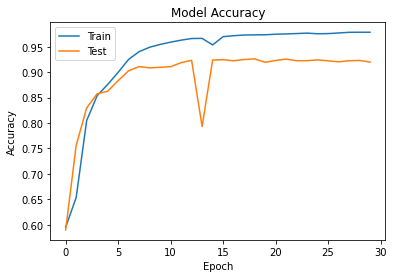

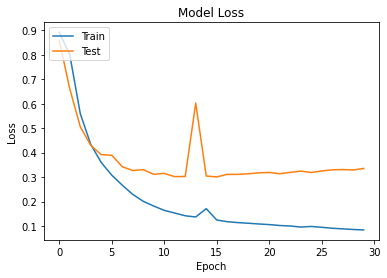

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title("Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()



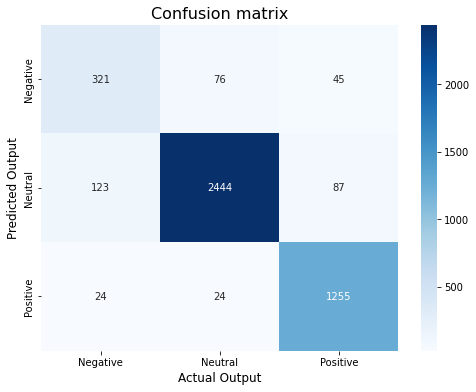

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual Output', fontsize=12)
    plt.ylabel('Predicted Output', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [30]:
# Saving the model
model.save('best_model.h5')

# Using the Model to make Sentiment Predictions 

In [31]:
from keras.models import load_model

model = load_model('best_model.h5')

# Function to predict the Sentiment of a text
def predict_class(text):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    xt = tokenizer.texts_to_sequences(text)
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    yt = model.predict(xt).argmax(axis=1)
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [32]:
# Sentences are used from the dataset.
predict_class(["The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."])

The predicted sentiment is Negative


In [33]:
predict_class(['The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .'])

The predicted sentiment is Negative


In [34]:
predict_class(['L&G still paying price for dividend cut during crisis, chief says'])

The predicted sentiment is Negative


# Twitter API 

In [35]:
import tweepy as tw

In [36]:
#Getting authorization

#consumer_key= <Your key goes here.>
#consumer_secret= <Your key goes here.>
#access_token= <Your access token goes here.>
#access_token_secret= <Your access token goes here.>

#auth = tw.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_token_secret)
#api = tw.API(auth, wait_on_rate_limit=True)

In [37]:
import tweepy
import re

client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAKeEdQEAAAAALRwVijmjxGWAOKircCl6hoWC%2BbQ%3DxKW0CjFTXd8JSlTAwHzZVzfXCnD1irr3U6qncWGbZ8oJOKMVIu')

# Replace with your own search query
query = 'Tesla  -is:retweet'

#tweets = client.search_recent_tweets(query=query, max_results=10)

#for tweet in tweets.data:
#    print(re.sub('@[^\s]+','',tweet.text))
#    if len(tweet.context_annotations) > 0:
#        print(tweet.context_annotations, "\n")   
#    predict_class([re.sub('@[^\s]+','',tweet.text)])  
#    print("_______________________________________________")
#    print(" ")